## Importing the Libraries

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import folium
import warnings
import IPython.display
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

### Analysis of Charging Stations in India

The columns in the dataset are:

1. name: The name of the charging station
2. state: The state where the charging station is located
3. city: The city where the charging station is located
4. address: The address of the charging station
5. lattitude: The latitude of the charging station
6. longitude: The longitude of the charging station
7. type: The type of charging station (slow, fast, or ultra-fast)

### Reading the Dataset

In [276]:
# Reading the charging dataset
charge_df = pd.read_csv("C:/Users/Ananth/OneDrive/Desktop/Fynlabs AI/ev_charging_stations_india.csv")
charge_df.head()

,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.9803,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.0818,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.2760,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.7218,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.7218,12.0


In [278]:
charge_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1547 non-null   object 
 1   state      1547 non-null   object 
 2   city       1547 non-null   object 
 3   address    1507 non-null   object 
 4   lattitude  1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1539 non-null   float64
dtypes: float64(2), object(5)
memory usage: 84.7+ KB


## Data Preprocessing

### Dropping Duplicate Data

In [282]:
# Drop duplicate values
print(f"Number of duplicate rows: {charge_df.duplicated().sum()}")
charge_df.drop_duplicates(inplace=True)

Number of duplicate rows: 205


### Dropping Missing Data

In [285]:
# Drop missing values
charge_df.dropna(inplace=True)
charge_df.reset_index(drop=True, inplace=True)

### Changing dtype of variables

In [288]:
# Changing the datatype of variables
charge_df["lattitude"] = charge_df["lattitude"].str.replace(',', '').astype(float)
charge_df["type"] = charge_df["type"].astype(int)

### Creating new variable `charge_speed`

In [291]:
# Creating a variable "charge_speed"
def encode_type(type_value):
    if type_value <= 11:
        return "slow"
    elif type_value <= 16:
        return "fast"
    else:
        return "ultra-fast"

charge_df["charge_speed"] = charge_df["type"].apply(encode_type)

### Cleaning the `lattitude` and `longitude` variables

In [294]:
charge_df.describe()

,lattitude,longitude,type
count,1291.000000,1.291000e+03,1291.000000
mean,19.907463,6.599958e+04,8.928737
std,6.932307,2.368613e+06,4.167747
min,8.390198,8.058454e+00,6.000000
25%,13.032111,7.578536e+01,7.000000
50%,19.051601,7.721756e+01,7.000000
75%,27.179942,7.846415e+01,10.000000
max,77.597289,8.510551e+07,24.000000


The maximum value for the `longitude` variable is 85105515 and minimum value is 8.0584540 which could be a mistake. Also the maximum value for the `lattitude` variable is 77.597289. As the `longitude` of India ranges from approximately 68 to 97, and `lattitude` ranges from 8 to 37, we will correct these values in the below cells.

In [297]:
# Correcting the maximum and minimum values of the longitude variable
charge_df.iloc[charge_df.longitude.argmax(), 5] = charge_df.iloc[charge_df.longitude.argmax(), 5] / 10e5
charge_df.iloc[charge_df.longitude.argmin(), 5] = charge_df.iloc[charge_df.longitude.argmin(), 5] * 10

In [299]:
index = charge_df.lattitude.argmax()
lat = charge_df.loc[charge_df.lattitude.argmax(), "lattitude"]

# Swap the values of latitude and longitude for row 535
charge_df.loc[index, "lattitude"] = charge_df.loc[index, "longitude"]
charge_df.loc[index, "longitude"] = lat

In [301]:
charge_df.describe()

,lattitude,longitude,type
count,1291.000000,1291.000000,1291.000000
mean,19.857340,77.586028,8.928737
std,6.746304,3.663208,4.167747
min,8.390198,69.678673,6.000000
25%,13.031820,75.794858,7.000000
50%,19.051601,77.217962,7.000000
75%,27.094893,78.466949,10.000000
max,32.991800,94.168072,24.000000


## Correcting the State Names

In [304]:
incorrect_state_name = {
    "Uttrakhand": "Uttarakhand",
    "Uttarkhand": "Uttarakhand",
    "Tamilnadu": "Tamil Nadu",
    "Taminadu": "Tamil Nadu",
    "Westbengal": "West Bengal",
    "Hyderabadu00A0": "Hyderabad",
    "Jammu": "Jammu & Kashmir",
    "Andhra pradesh": "Andhra Pradesh",
    "Andra Pradesh": "Andhra Pradesh",
    "Andhrapradesh": "Andhra Pradesh",
    "Rajahmundry": "Andhra Pradesh",
    "Puducherry": "Pondicherry",
    "Bhubhaneswar": "Odisha",
    "Chattisgarh": "Chhattisgarh",
    "Chikhali": "Maharashtra",
    "Maharashra": "Maharashtra",
    "Delhi Ncr": "Delhi",
    "Ernakulam": "Kerala",
    "Karala": "Kerala",
    "Kochi": "Kerala",
    "Hisar": "Haryana",
    "Harayana": "Haryana",
    "Jajpur": "Rajasthan",
    "Limbdi": "Gujarat",
    "Andaman": "Andaman & Nicobar",
}

charge_df["state"] = charge_df["state"].str.strip().str.title()
charge_df["state"] = charge_df["state"].replace(incorrect_state_name)
charge_df["state"] = charge_df["state"].str.strip().str.title()

## Correcting the City Names

In [307]:
incorrect_city_name = {
    "Delhi": "New Delhi",
    "Bengaluru": "Bangalore"
}

charge_df["city"] = charge_df["city"].str.strip().str.title()
charge_df["city"] = charge_df["city"].replace(incorrect_city_name)

## EDA 

### Top 10 states with maximum charging stations

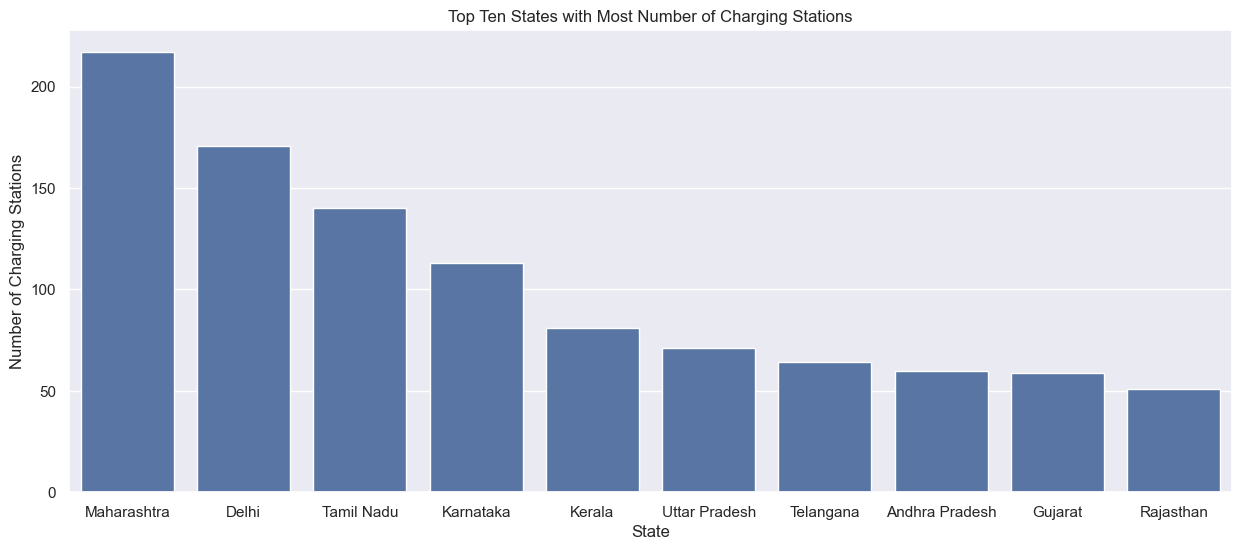

In [311]:
# Get the top ten states with most number of charging stations.
top_ten_states = charge_df["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states["state"], y=top_ten_states["count"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Most Number of Charging Stations")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by state. The state with the most number of charging stations is `Maharashtra`, followed by `Delhi` and `Tamil Nadu`.

### Top 10 Cities With Maximum Charging Stations

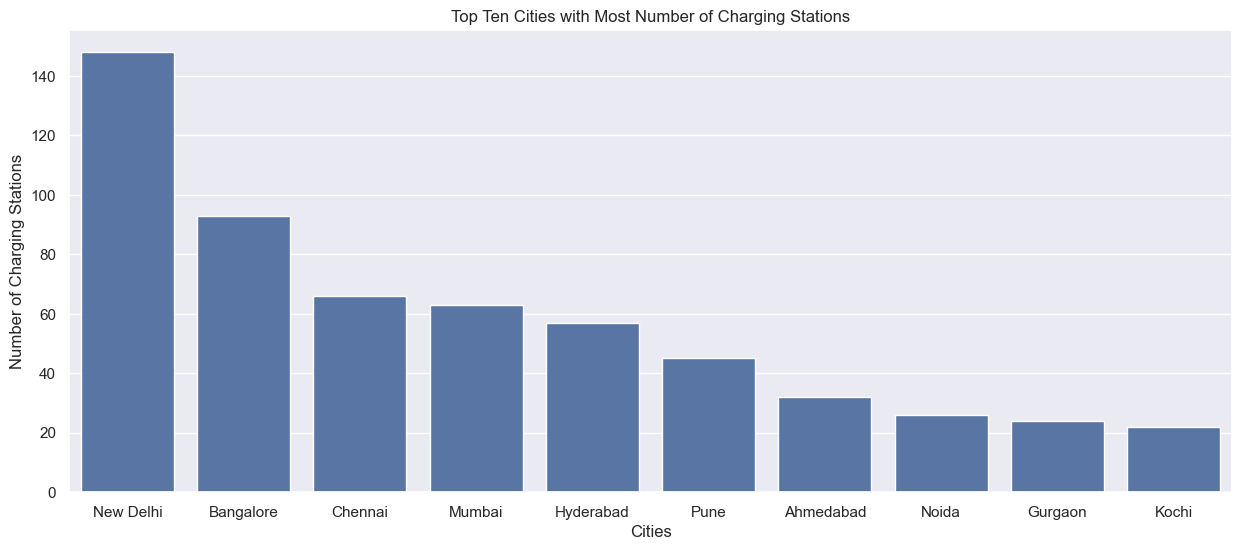

In [315]:
# Get the top ten cities with most number of charging stations.
top_ten_city = charge_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_city["city"], y=top_ten_city["count"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Most Number of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by city. The city with the most number of charging stations is `New Delhi`, followed by `Bangalore` , `Chennai` and `Mumbai`. We can see that the top 4 cities are metropolitan cities.

## Distribution of Different Types of Charging Stations

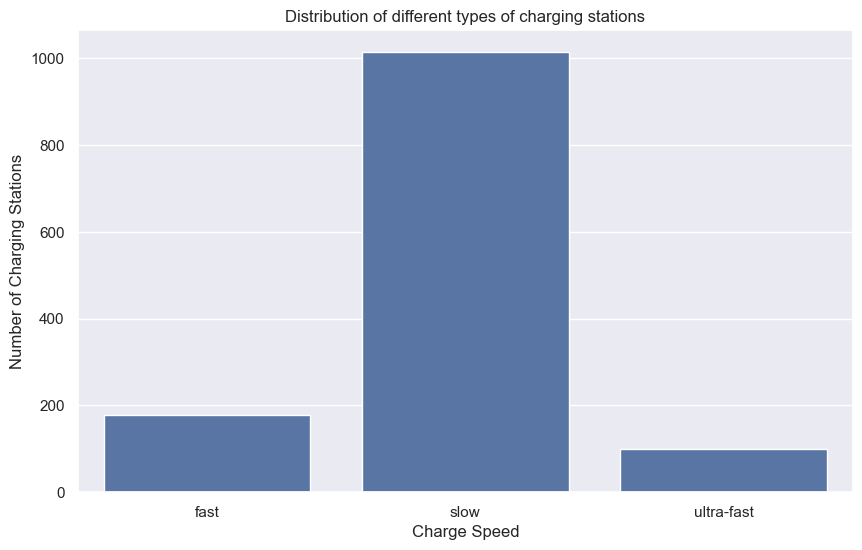

In [319]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.countplot(data=charge_df, x="charge_speed")

# Add a title and labels to the axes.
plt.title("Distribution of different types of charging stations")
plt.xlabel("Charge Speed")
plt.ylabel("Number of Charging Stations");

Most of the charging stations in India provide slow charging for the EV. There are very few ultra-fast charging stations.

### States With Fast Charging Stations

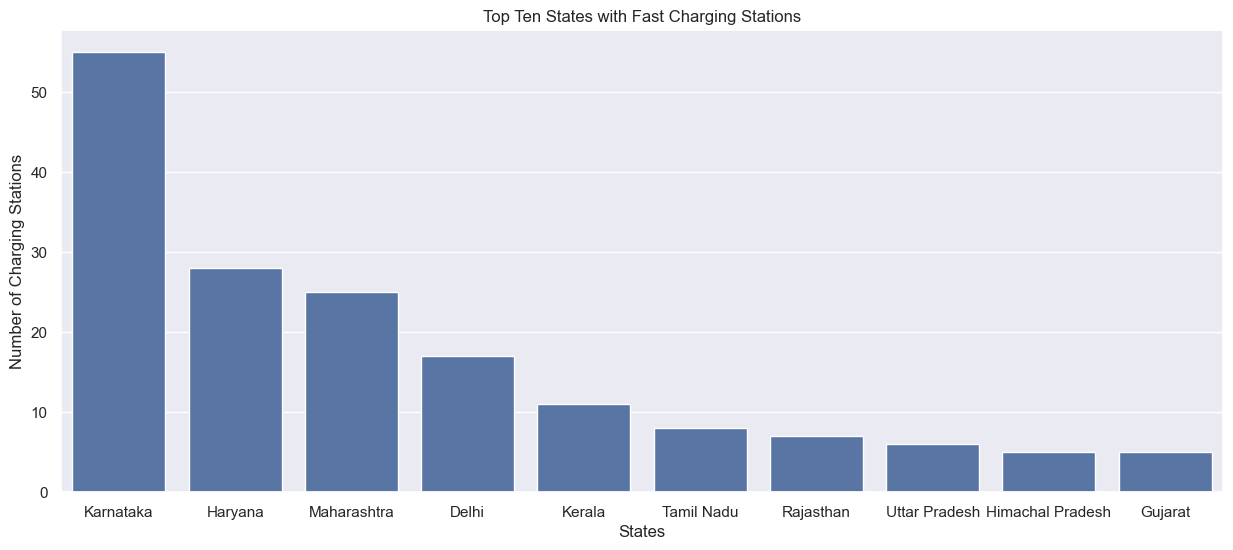

In [323]:
fast_charge = charge_df.query("charge_speed == 'fast'")
top_ten_states_fast = fast_charge["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_fast["state"], y=top_ten_states_fast["count"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Fast Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

Karnataka has the highest number of fast charging stations.

### Cities With Fast Charging Stations

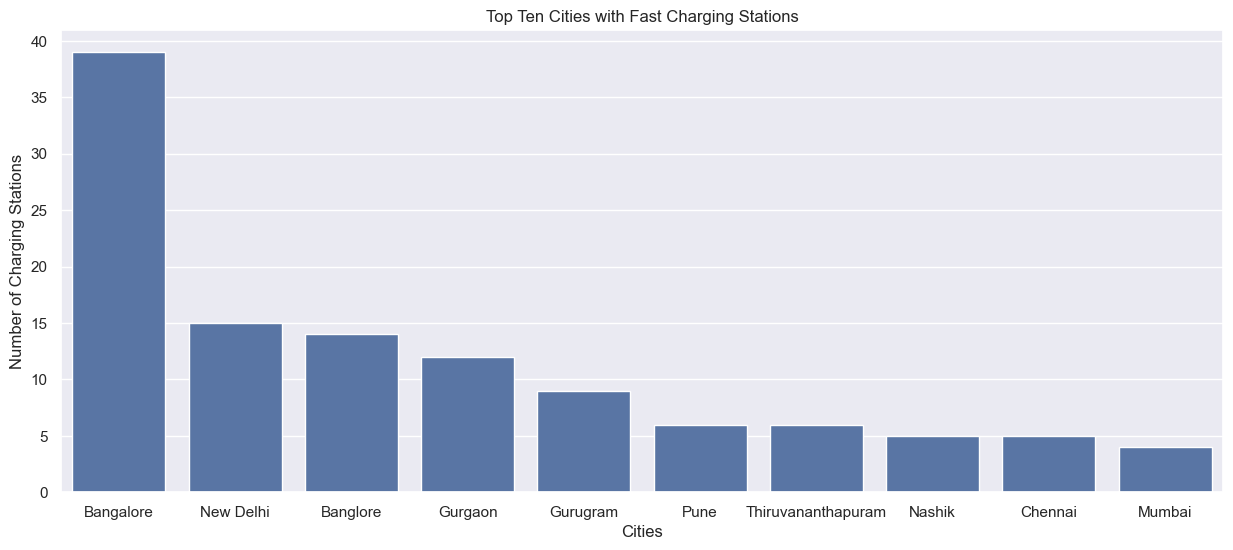

In [326]:
top_ten_cities_fast = fast_charge["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_fast["city"], y=top_ten_cities_fast["count"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Fast Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

Bangalore has the highest number of fast charging stations.

### States With Ultra-Fast Charging Stations

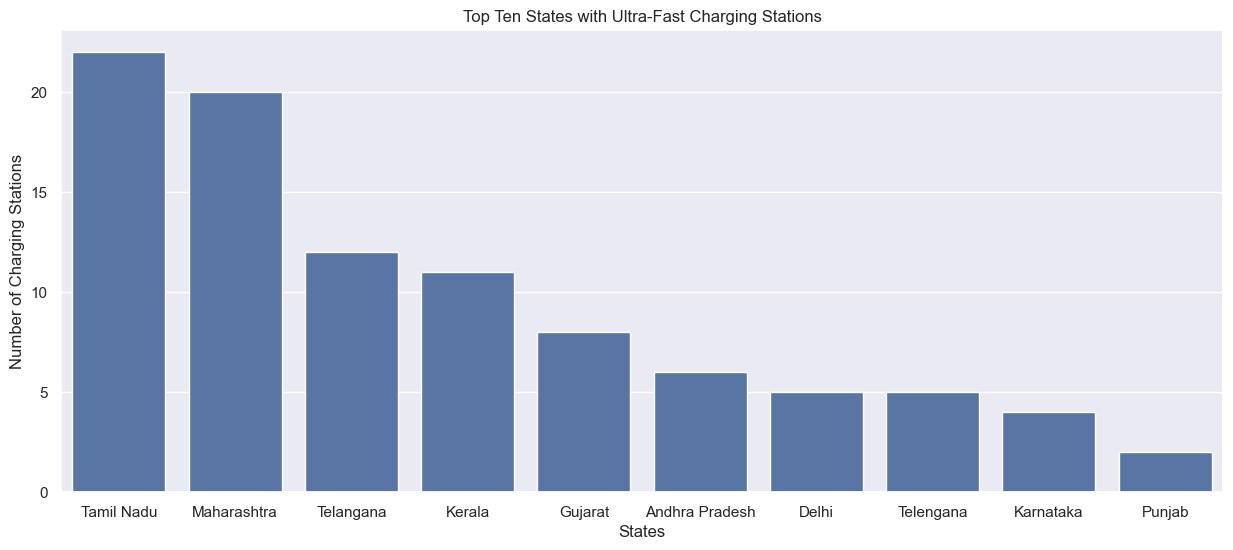

In [330]:
ultra_fast_charge = charge_df.query("charge_speed == 'ultra-fast'")
top_ten_states_ultra_fast = ultra_fast_charge["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_ultra_fast["state"], y=top_ten_states_ultra_fast["count"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Ultra-Fast Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

`Tamil Nadu` and `Maharashtra` has the highest number of ultra-fast charging stations.

### Cities With Ultra-Fast Charging Stations

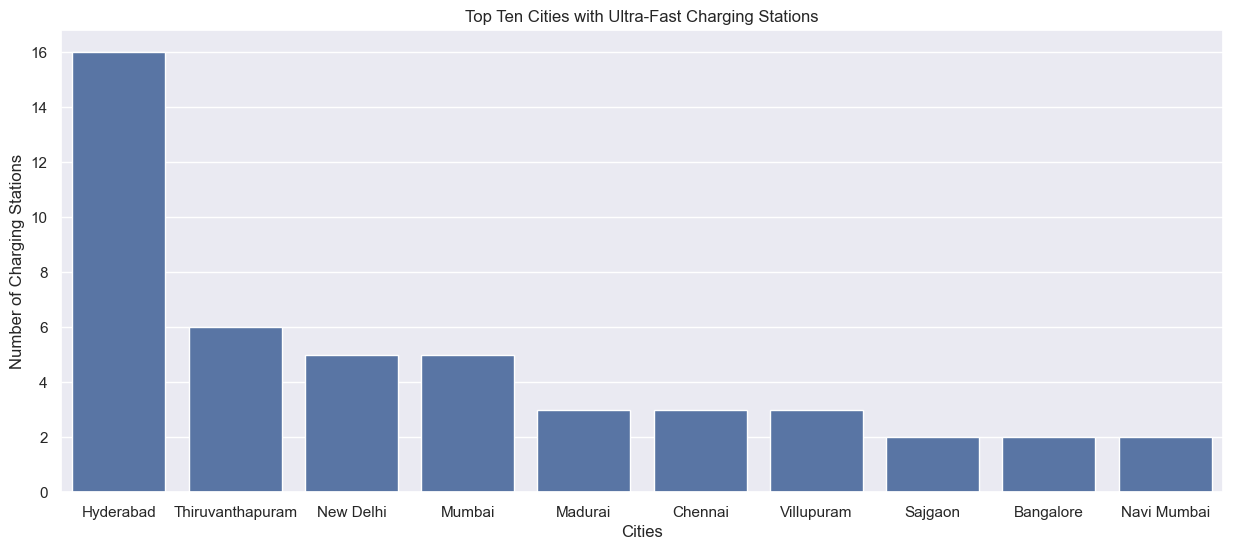

In [334]:
top_ten_cities_ultra_fast = ultra_fast_charge["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_ultra_fast["city"], y=top_ten_cities_ultra_fast["count"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Ultra-Fast Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

`Hyderabad` has the highest number of ultra-fast charging stations.

### Locations of Charging Stations in India

In [337]:
# Create a map of India.
map_india = folium.Map(location=[22.68, 79.04], zoom_start=6)

# Add markers to the map for each charging station.
for i in range(len(charge_df)):
    latitude = charge_df.loc[i, "lattitude"]
    longitude = charge_df.loc[i, "longitude"]
    marker = folium.Marker([latitude, longitude], popup=charge_df.loc[i, "name"])
    marker.add_to(map_india)

# Display the map in Jupyter Notebook.
IPython.display.display(map_india)

The density of charging stations in the southern parts of India is more compared to the nouthern parts.

In [340]:
map_india.save("map_of_charge_stations.html")

### Observations

1. The distribution of charge stations in India is uneven, with the majority of stations located in the states of Maharashtra, Delhi, and Tamil Nadu.
2. The city with the most number of charge stations is New Delhi, followed by Bangalore and Chennai. These cities are all major metropolitan areas with a high demand for electric vehicles.
3. Most of the charge stations in India provide slow charging for EVs, while there are very few ultra-fast charging stations. This is likely due to the high cost of ultra-fast chargers.
4. Karnataka has the highest number of fast charge stations in India, followed by Maharashtra and Telangana.
5. Bangalore City has the highest number of fast charge stations in India.
6. Tamil Nadu and Maharashtra have the highest number of ultra-fast charge stations in India, followed by Telangana and Karnataka.
7. Hyderabad City has the highest number of ultra-fast charge stations in India.

These observations suggest that the demand for electric vehicles is highest in the major metropolitan areas of India. The government of India should focus on developing charging infrastructure in these areas to support the growth of the electric vehicle market.

## Analysis of EV Population Data

The dataset includes the following columns:

1. VIN (1-10): The vehicle identification number (VIN) of the electric vehicle.
2. County: The county where the electric vehicle is registered.
3. City: The city where the electric vehicle is registered.
4. State: The state where the electric vehicle is registered.
5. ZIP Code: The ZIP code where the electric vehicle is registered.
6. Model Year: The model year of the electric vehicle.
7. Make: The make of the electric vehicle.
8. Model: The model of the electric vehicle.
9. Electric Vehicle Type: The type of electric vehicle, such as battery electric vehicle (BEV) or plug-in hybrid electric vehicle (PHEV).
10. Clean Alternative Fuel Vehicle (CAFV) Eligibility: Whether the electric vehicle is eligible for Clean Alternative Fuel Vehicle (CAFV) incentives.
11. Electric Range: The electric range of the electric vehicle in miles.
12. Base MSRP: The base manufacturer's suggested retail price (MSRP) of the electric vehicle in US dollars.
13. Legislative District: The legislative district where the electric vehicle is registered.
14. DOL Vehicle ID: The vehicle identification number assigned by the Department of Licensing (DOL) of the state of Washington.
15. Vehicle Location: The location of the electric vehicle, represented as a point in geographic coordinates.

### Reading the dataset

In [347]:
# Reading the ev population dataset
evpopulation_df = pd.read_csv("C:/Users/Ananth/OneDrive/Desktop/Fynlabs AI/Electric_Vehicle_Population_Data.csv")
evpopulation_df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,1N4AZ0CP5D,Kitsap,Bremerton,WA,98310.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,23.0,214384901,POINT (-122.61136499999998 47.575195000000065)
1,1N4AZ1CP8K,Kitsap,Port Orchard,WA,98366.0,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,0,26.0,271008636,POINT (-122.63926499999997 47.53730000000007)
2,5YJXCAE28L,King,Seattle,WA,98199.0,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,293,0,36.0,8781552,POINT (-122.394185 47.63919500000003)
3,SADHC2S1XK,Thurston,Olympia,WA,98503.0,2019,JAGUAR,I-PACE,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,234,0,2.0,8308492,POINT (-122.8285 47.03646)
4,JN1AZ0CP9B,Snohomish,Everett,WA,98204.0,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,21.0,245524527,POINT (-122.24128499999995 47.91088000000008)


In [348]:
evpopulation_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138779 entries, 0 to 138778
Data columns (total 15 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         138779 non-null  object 
 1   County                                             138776 non-null  object 
 2   City                                               138776 non-null  object 
 3   State                                              138779 non-null  object 
 4   Postal Code                                        138776 non-null  float64
 5   Model Year                                         138779 non-null  int64  
 6   Make                                               138779 non-null  object 
 7   Model                                              138493 non-null  object 
 8   Electric Vehicle Type                              138779 non-null  object

## Data Preprocessing

### Dropping Duplicate Data

In [351]:
# Drop duplicate values
print(f"Number of duplicate rows: {evpopulation_df.duplicated().sum()}")
evpopulation_df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


### Dropping Missing Data

In [353]:
# Drop missing values
evpopulation_df.dropna(inplace=True)
evpopulation_df.reset_index(drop=True, inplace=True)

### Changing dtype of variables

In [355]:
# Changing the datatype of variables
evpopulation_df["Model Year"] = evpopulation_df["Model Year"].astype(int)

## EDA 

In [357]:
evpopulation_df.describe().loc[:, ["Model Year", "Electric Range", "Base MSRP"]]

,Model Year,Electric Range,Base MSRP
count,138175.000000,138175.000000,138175.000000
mean,2019.766441,72.448981,1407.425982
std,3.012774,97.809794,9551.756736
min,1997.000000,0.000000,0.000000
25%,2018.000000,0.000000,0.000000
50%,2021.000000,21.000000,0.000000
75%,2022.000000,149.000000,0.000000
max,2024.000000,337.000000,845000.000000


### Count of Types of Electric Vehicles

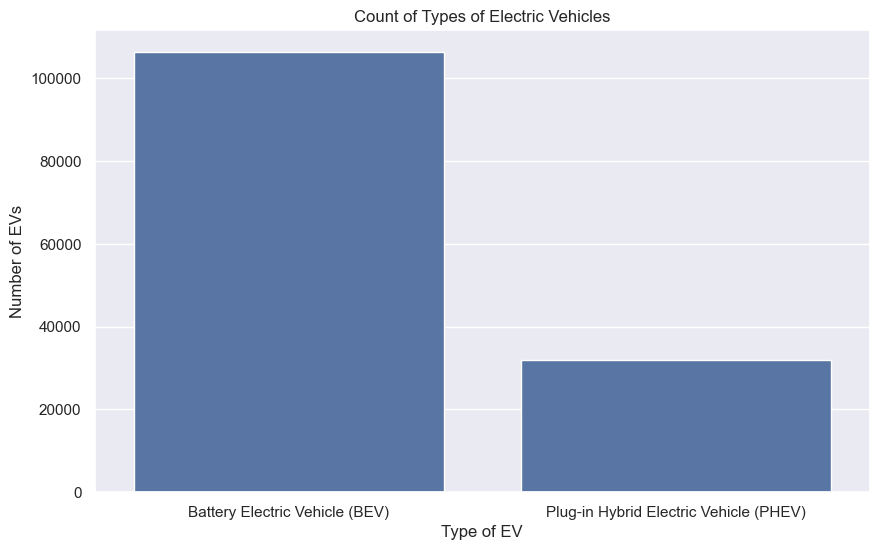

In [359]:
count_ev_type = evpopulation_df["Electric Vehicle Type"].value_counts().sort_values(ascending=False).reset_index()

# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=count_ev_type["Electric Vehicle Type"], y=count_ev_type["count"])

# Add a title and labels to the axes.
plt.title("Count of Types of Electric Vehicles")
plt.xlabel("Type of EV")
plt.ylabel("Number of EVs");

Most of the Electric Vehicles in the US market are `Battery Electric Vehicles (BEV)`.

### Population of EVs over Years

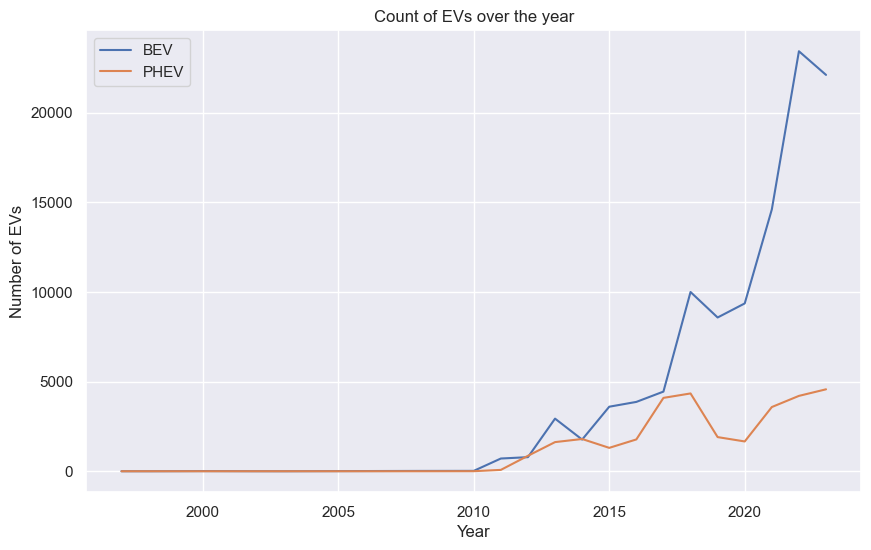

In [363]:
yearly_population = pd.crosstab(evpopulation_df["Model Year"], evpopulation_df["Electric Vehicle Type"]).iloc[:-1, :]

plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_population.index, y=yearly_population["Battery Electric Vehicle (BEV)"], label="BEV")
sns.lineplot(x=yearly_population.index, y=yearly_population["Plug-in Hybrid Electric Vehicle (PHEV)"], label="PHEV")

# Add a title and labels to the axes.
plt.title("Count of EVs over the year")
plt.xlabel("Year")
plt.ylabel("Number of EVs")
plt.legend();

The amount of EVs made in the US has increased drastically over the years. Battery Electric Vehicle (BEV)s has seen an exponential growth in the last 13 years. The growth in Plug-in Hybrid Electric Vehicle (PHEV)s is not as drastic as BEVs but has grown linearly over the years.

### Distribution of EVs by Make

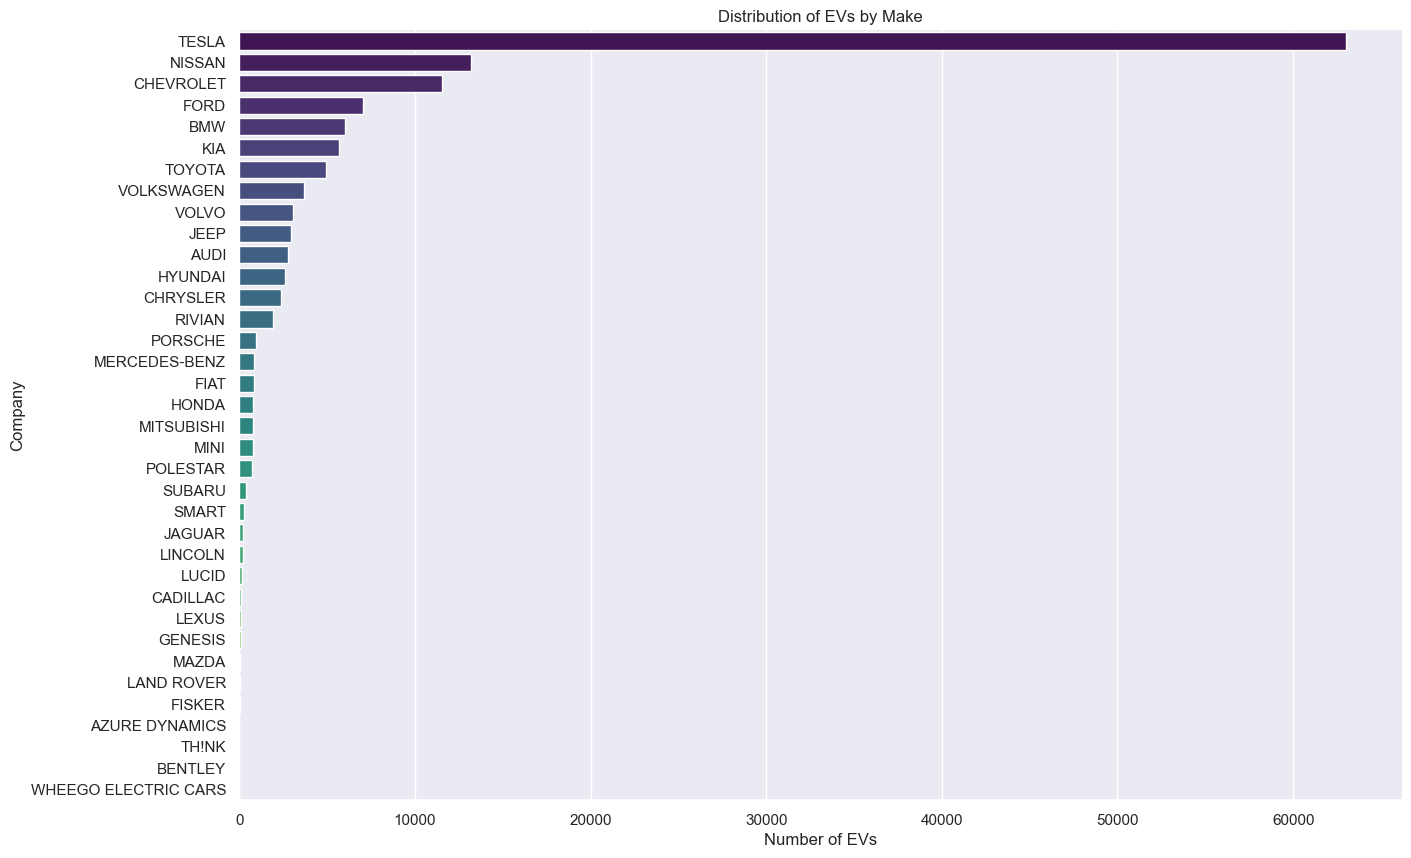

In [366]:
plt.figure(figsize=(15, 10))
sns.countplot(
    data=evpopulation_df,
    y="Make",
    palette="viridis",
    order=evpopulation_df["Make"].value_counts().index,
 )

plt.title("Distribution of EVs by Make")
plt.xlabel("Number of EVs")
plt.ylabel("Company")
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
sns.despine()

Almost 46% of the EVs made in the US from 1997 are manufactured by Tesla.

### Distribution of CAFV Eligibility

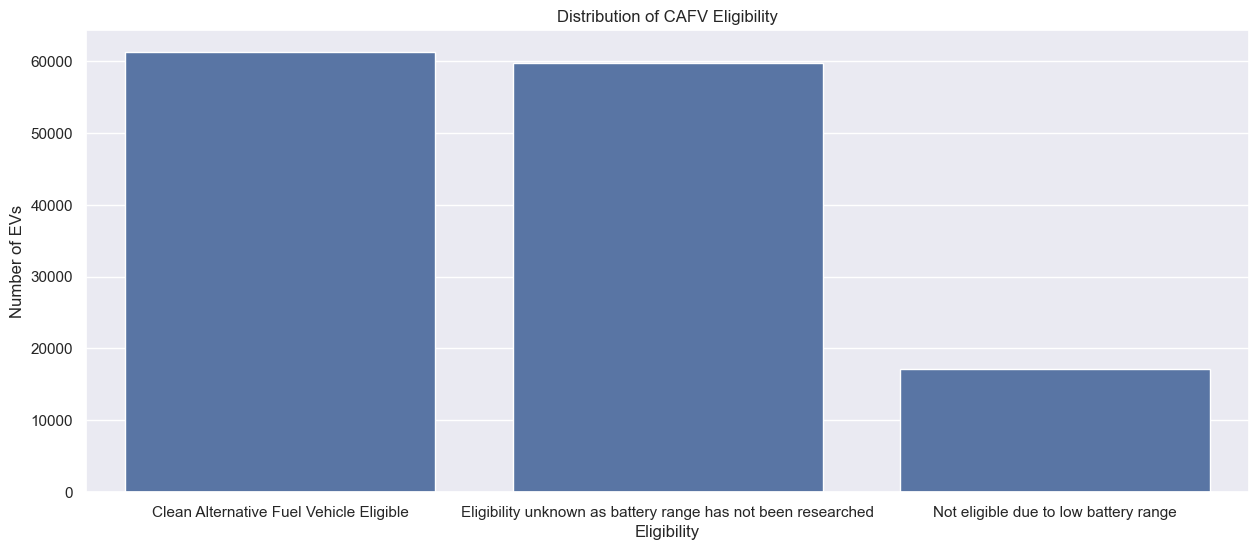

In [369]:
cafv_eligibility = evpopulation_df["Clean Alternative Fuel Vehicle (CAFV) Eligibility"].value_counts().sort_values(ascending=False).reset_index()

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=cafv_eligibility["Clean Alternative Fuel Vehicle (CAFV) Eligibility"], y=cafv_eligibility["count"])

# Add a title and labels to the axes.
plt.title("Distribution of CAFV Eligibility")
plt.xlabel("Eligibility")
plt.ylabel("Number of EVs");

Above 60,000 EVs are eligible for clean alternative fuel. Yet other 60,000 EVs have not been researched to decide eligibility.

### Distribution of Electric Range

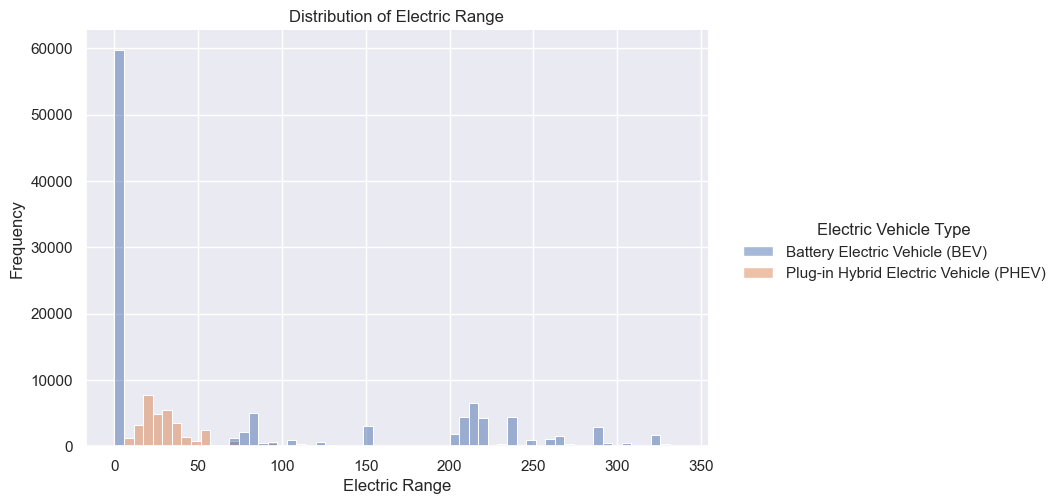

In [372]:
# Create a bar chart.
# plt.figure(figsize=(15, 6))
sns.displot(data=evpopulation_df, x="Electric Range", aspect=1.5, hue="Electric Vehicle Type")

# Add a title and labels to the axes.
plt.title("Distribution of Electric Range")
plt.xlabel("Electric Range")
plt.ylabel("Frequency");

Most of the vehicles in the dataset have zero Electric Range.Electric Range is no longer maintained for Battery Electric Vehicles because new BEVs have an electric range of 30 miles or more. Zero (0) has been entered where the electric range has not been researched. Other than these BEVs the rest of the vehicles Electric Range are clustered between 20 to 40 miles and 200 to 250 miles. We can also see that the PHEVs have lower range than BEVs in general.

## Observations

1. The electric vehicle (EV) market in the United States has seen significant growth in recent years, with battery electric vehicles (BEVs) accounting for the majority of EVs sold.
2. The number of EVs made in the US has increased exponentially over the past 13 years, with BEVs leading the way. PHEVs have also seen growth, but not as drastic as BEVs.
3. Tesla is the leading manufacturer of EVs in the US, accounting for nearly half of all EVs sold since 1997.
More than 60,000 EVs are eligible for clean alternative fuel (CAF) incentives, while another 60,000 have not yet been researched to determine eligibility.
4. Most of the electric vehicles have an electric range that is clustered between 20 to 40 miles and 200 to 250 miles. PHEVs, in general, have a lower range than BEVs.

These findings indicate that the electric vehicle (EV) market in the United States is expanding quickly, with battery electric vehicles (BEVs) at the forefront. Tesla stands out as the leading EV manufacturer in the country, and a substantial portion of EVs qualify for CAF incentives. However, there remains a notable gap in data regarding the electric range of numerous EV models.

## Analysis of Indian Automobile Buying Behavior Data

The dataset includes the following columns:

1. Age: The age of the buyer.
2. Profession: The occupation of the buyer.
3. Marital Status: The marital status of the buyer.
4. Education: The highest level of education of the buyer.
5. No of Dependents: The number of dependents of the buyer.
6. Personal loan: Whether the buyer has a personal loan.
7. House Loan: Whether the buyer has a house loan.
8. Wife Working: Whether the wife of the buyer is working.
9. Salary: The salary of the buyer.
10. Wife Salary: The salary of the wife of the buyer.
11. Total Salary: The combined salary of the buyer and wife.
12. Make: The make of the automobile purchased.
13. Price: The price of the automobile purchased.

### Reading the dataset

In [385]:
# Reading the automobile buying behavior dataset
behavior_df = pd.read_csv("C:/Users/Ananth/OneDrive/Desktop/Fynlabs AI/Indian_automoble_buying_behavour_data.csv")
behavior_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price
0,27,Salaried,Single,Post Graduate,0,Yes,No,No,800000,0,800000,i20,800000
1,35,Salaried,Married,Post Graduate,2,Yes,Yes,Yes,1400000,600000,2000000,Ciaz,1000000
2,45,Business,Married,Graduate,4,Yes,Yes,No,1800000,0,1800000,Duster,1200000
3,41,Business,Married,Post Graduate,3,No,No,Yes,1600000,600000,2200000,City,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,No,Yes,1800000,800000,2600000,SUV,1600000


In [387]:
behavior_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               99 non-null     int64 
 1   Profession        99 non-null     object
 2   Marrital Status   99 non-null     object
 3   Education         99 non-null     object
 4   No of Dependents  99 non-null     int64 
 5   Personal loan     99 non-null     object
 6   House Loan        99 non-null     object
 7   Wife Working      99 non-null     object
 8   Salary            99 non-null     int64 
 9   Wife Salary       99 non-null     int64 
 10  Total Salary      99 non-null     int64 
 11  Make              99 non-null     object
 12  Price             99 non-null     int64 
dtypes: int64(6), object(7)
memory usage: 10.2+ KB


## EDA

In [390]:
behavior_df.describe()

,Age,No of Dependents,Salary,Wife Salary,Total Salary,Price
count,99.000000,99.000000,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01
mean,36.313131,2.181818,1.736364e+06,5.343434e+05,2.270707e+06,1.194040e+06
std,6.246054,1.335265,6.736217e+05,6.054450e+05,1.050777e+06,4.376955e+05
min,26.000000,0.000000,2.000000e+05,0.000000e+00,2.000000e+05,1.100000e+05
25%,31.000000,2.000000,1.300000e+06,0.000000e+00,1.550000e+06,8.000000e+05
50%,36.000000,2.000000,1.600000e+06,5.000000e+05,2.100000e+06,1.200000e+06
75%,41.000000,3.000000,2.200000e+06,9.000000e+05,2.700000e+06,1.500000e+06
max,51.000000,4.000000,3.800000e+06,2.100000e+06,5.200000e+06,3.000000e+06


## Distribution of Numerical Variables

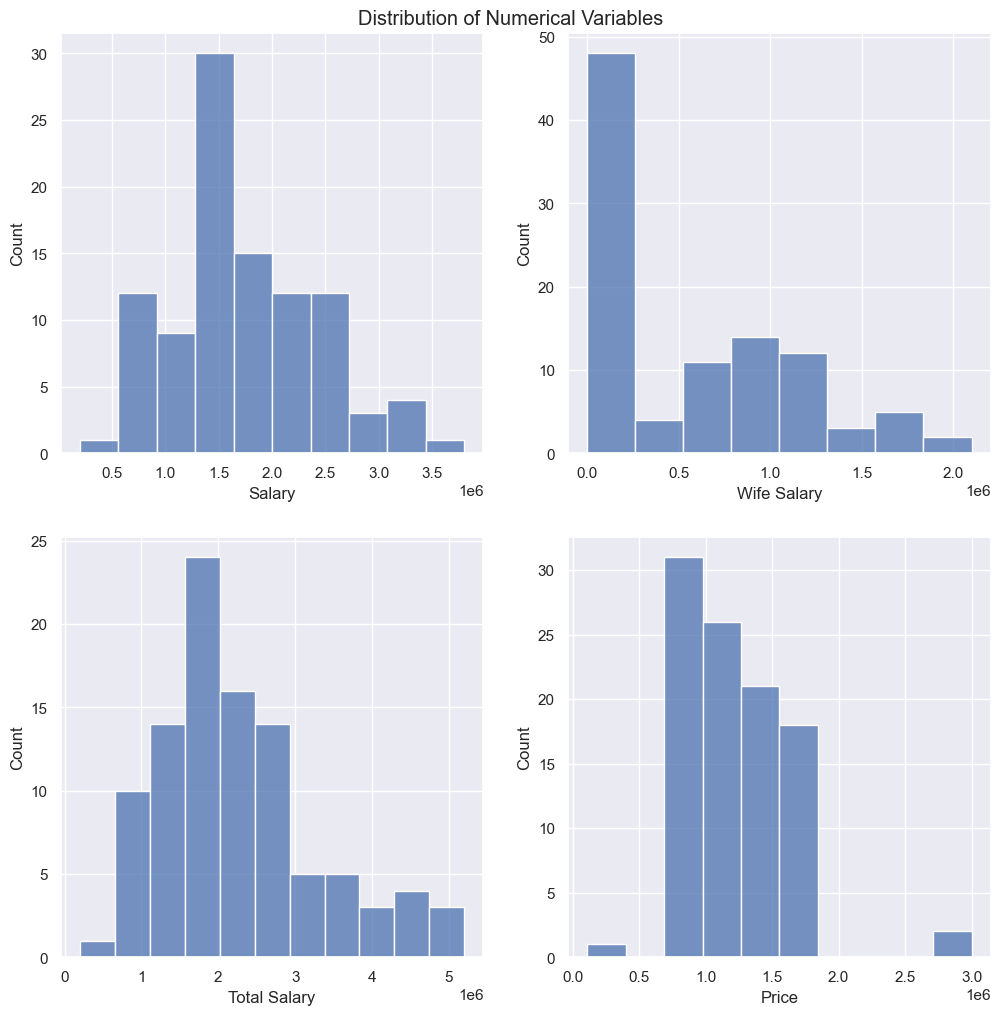

In [392]:
num_cols = ["Salary", "Wife Salary", "Total Salary", "Price"]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    sns.histplot(data=behavior_df, x=num_cols[i], ax=ax)
plt.suptitle("Distribution of Numerical Variables", y=0.9);

1. The Salary of the customers is grouped around 1000000 and 2500000.
2. Wife's salary for most of the customers is zero. For those whose wife is working the salary is between 500000 and 1500000.
3. The Total household salary of the customer is between 1000000 and 3000000.
4. The Price of the cars purchased by the customers range between 500000 to 2000000.

### Distribution of Profession variable

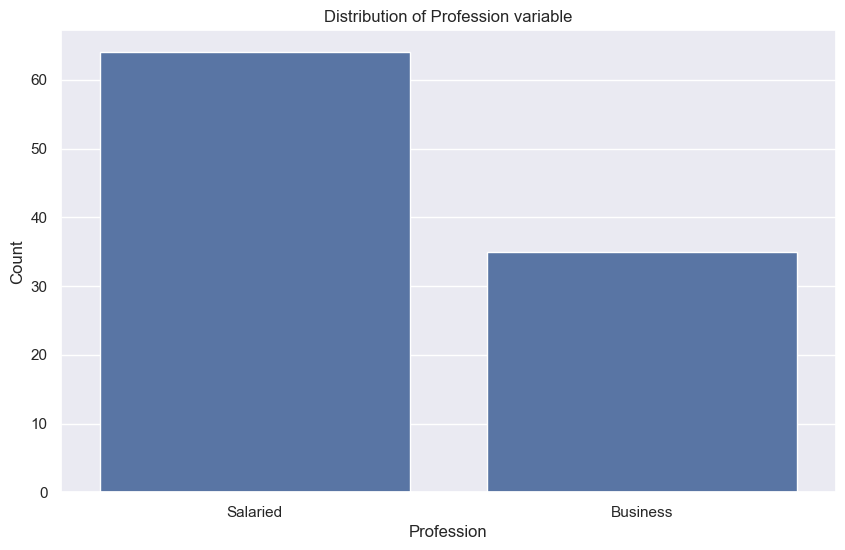

In [395]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Profession"].value_counts().index, y=behavior_df["Profession"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Profession variable")
plt.xlabel("Profession")
plt.ylabel("Count");

Around 65% customers are Salaried while 35% have their own business.

### Distribution of Marrital Status variable

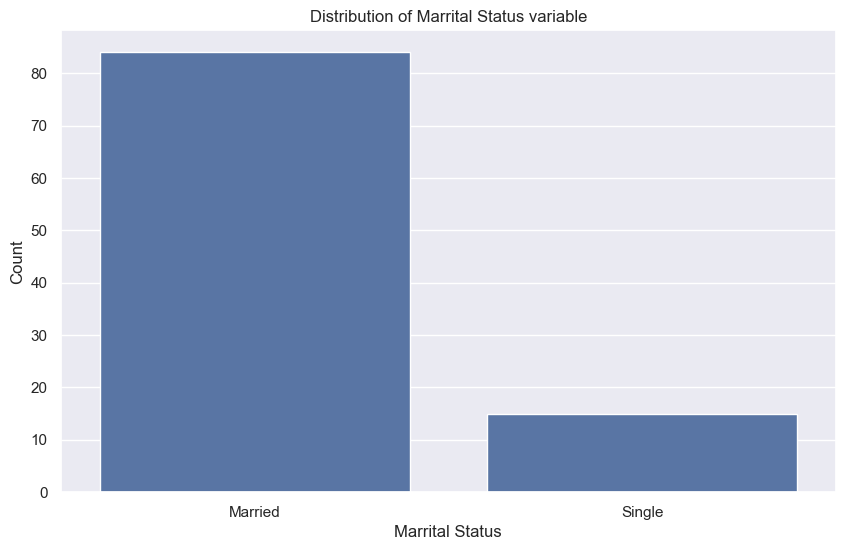

In [398]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Marrital Status"].value_counts().index, y=behavior_df["Marrital Status"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Marrital Status variable")
plt.xlabel("Marrital Status")
plt.ylabel("Count");

Most of the customers in the dataset are Married.

### Distribution of Education variable

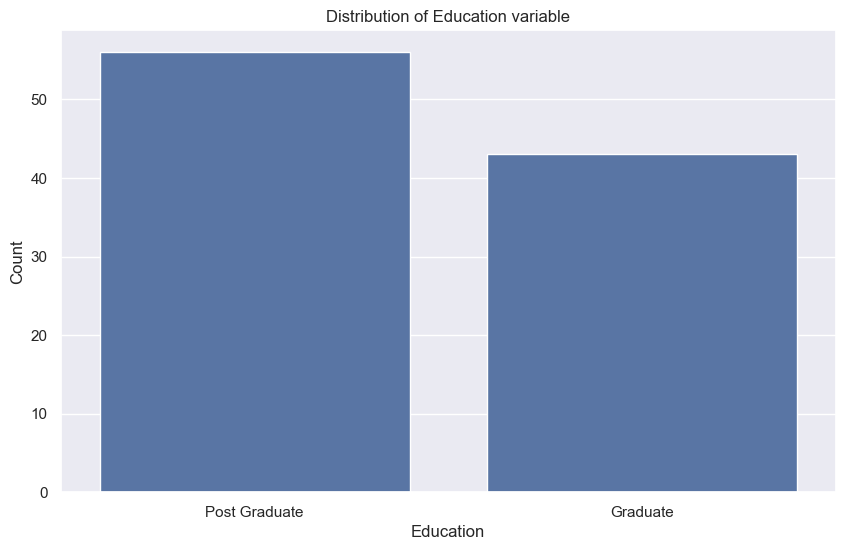

In [402]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Education"].value_counts().index, y=behavior_df["Education"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Education variable")
plt.xlabel("Education")
plt.ylabel("Count");

Around 55% customers hold a Post Graduate degree while 35% have a Graduate degree.

### Distribution of No of Dependents variable

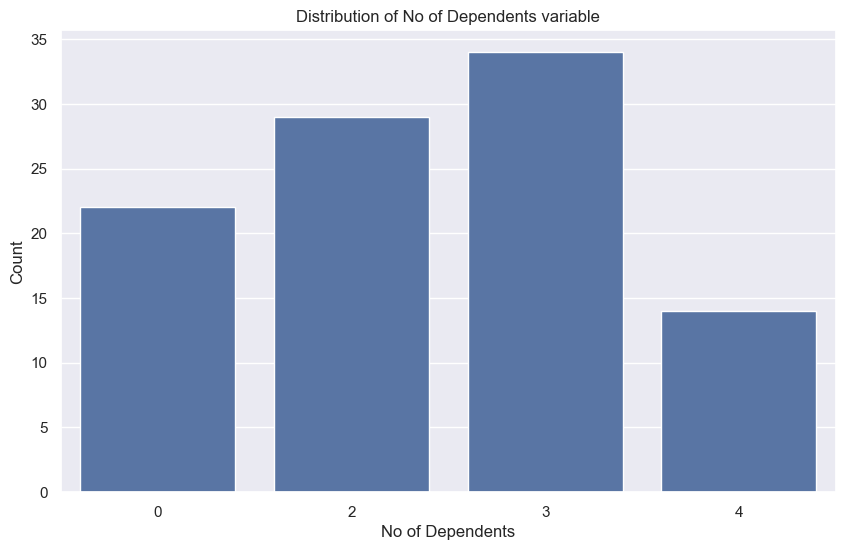

In [405]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["No of Dependents"].value_counts().index, y=behavior_df["No of Dependents"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of No of Dependents variable")
plt.xlabel("No of Dependents")
plt.ylabel("Count");

Most of the customers have 3 and 2 dependents.

### Distribution of Personal loan variable

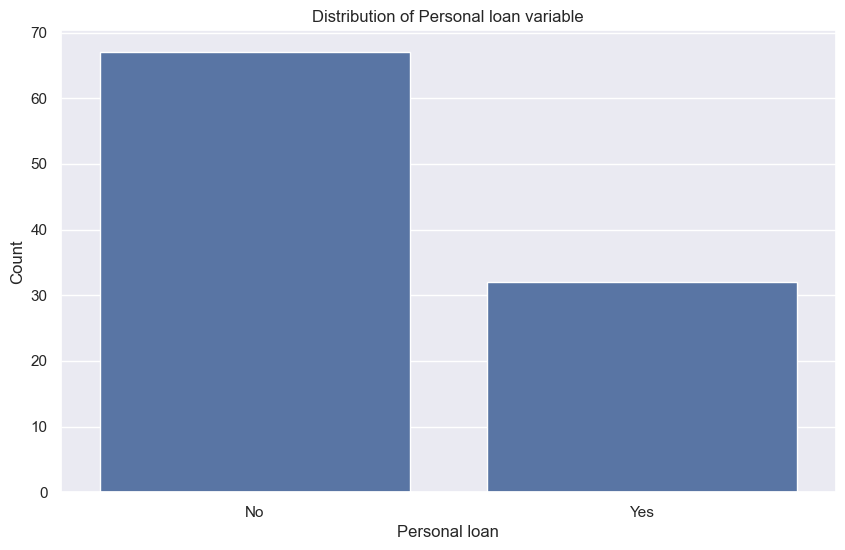

In [408]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Personal loan"].value_counts().index, y=behavior_df["Personal loan"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Personal loan variable")
plt.xlabel("Personal loan")
plt.ylabel("Count");

Around 68% of the customers do not have a personal loan.

### Distribution of House Loan variable

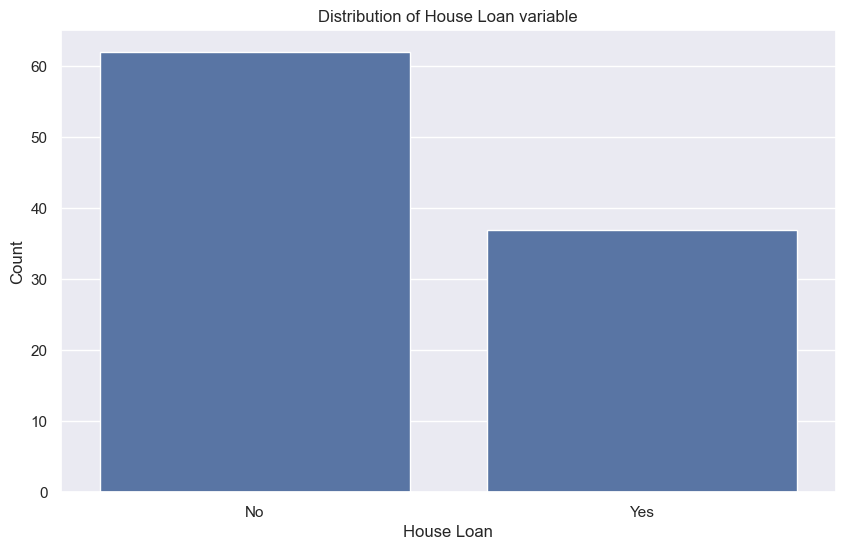

In [411]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["House Loan"].value_counts().index, y=behavior_df["House Loan"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of House Loan variable")
plt.xlabel("House Loan")
plt.ylabel("Count");

Around 61% of the customers do not have a house loan.

### Distribution of Wife Working variable

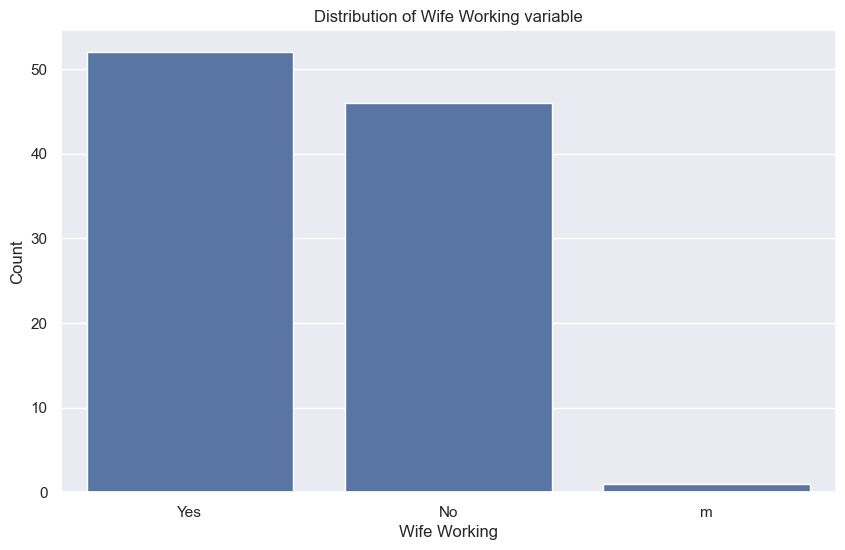

In [414]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Wife Working"].value_counts().index, y=behavior_df["Wife Working"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Wife Working variable")
plt.xlabel("Wife Working")
plt.ylabel("Count");

Around 52% of the customer's wifes are working. There is a third category "m" which seems to be a mistake. We will merge this category with the "Yes" category.

### Distribution of Make variable

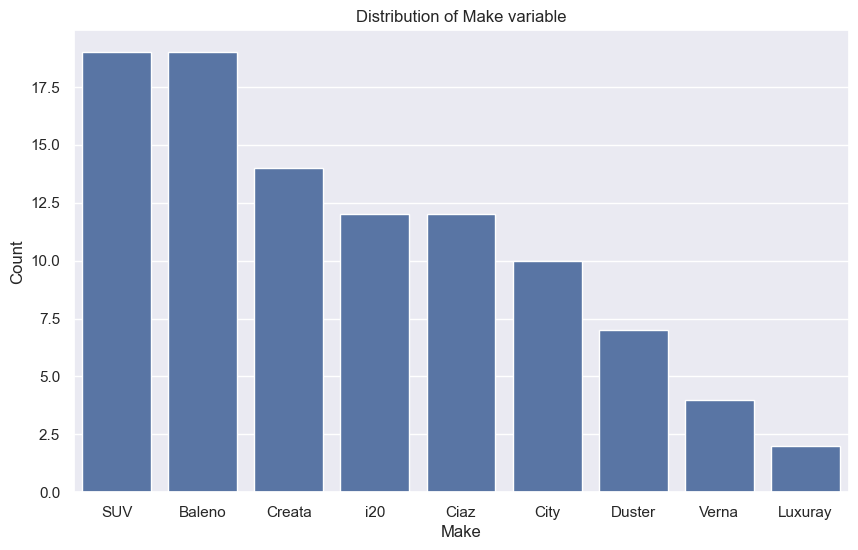

In [417]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior_df["Make"].value_counts().index, y=behavior_df["Make"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Make variable")
plt.xlabel("Make")
plt.ylabel("Count");

Most of the customers have purchased SUV and Baleno followed by Creata. Very few customers have bought Luxuray.

## Observations

1. The salary of the customers is grouped around 1000000 and 2500000 Indian rupees. This suggests that the majority of the customers in the dataset are from the upper-middle class or upper class.
2. Wife's salary for most of the customers is zero. For those whose wife is working, the salary is between 500000 and 1500000 Indian rupees.
3. The total household salary of the customer is between 1000000 and 3000000 Indian rupees. This suggests that the majority of the customers in the dataset have a comfortable financial situation.
4. The price of the cars purchased by the customers range between 500000 and 2000000 Indian rupees. This suggests that the majority of the customers in the dataset have purchased mid-range cars.
5. Around 65% of the customers are salaried while 35% have their own business. This suggests that the majority of the customers in the dataset are employed professionals.
6. Most of the customers in the dataset are married. This suggests that the majority of the customers in the dataset are in a stable family situation.
7. Around 55% of the customers hold a post-graduate degree while 35% have a graduate degree. This suggests that the majority of the customers in the dataset are well-educated.
8. Most of the customers have 3 and 2 dependents. This suggests that the majority of the customers in the dataset have young families.
9. Around 68% of the customers do not have a personal loan. This suggests that the majority of the customers in the dataset are able to afford the cars they have purchased without taking out a loan.
10. Around 61% of the customers do not have a house loan. This suggests that the majority of the customers in the dataset are able to afford to buy a house without taking out a loan.
11. Around 52% of the customer's wives are working. This suggests that the majority of the wives of the customers in the dataset are employed.12. 
Most of the customers have purchased SUV and Baleno followed by Creata. Very few customers have bought Luxury. This suggests that the majority of the customers in the dataset are interested in practical and fuel-efficient cars.

## Data Preprocessing

### Dropping Duplicate Data

In [425]:
# Drop duplicate values
print(f"Number of duplicate rows: {behavior_df.duplicated().sum()}")
behavior_df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


### Cleaning the Wife Working variable

In [427]:
behavior_df["Wife Working"].value_counts()

Wife Working
Yes    52
No     46
m       1
Name: count, dtype: int64

In [428]:
behavior_df["Wife Working"] = behavior_df["Wife Working"].replace({"m": "Yes"})
behavior_df["Wife Working"].value_counts()

Wife Working
Yes    53
No     46
Name: count, dtype: int64

### Encoding the Categorical Variables

In [430]:
segmentation_df = behavior_df.copy()
segmentation_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price
0,27,Salaried,Single,Post Graduate,0,Yes,No,No,800000,0,800000,i20,800000
1,35,Salaried,Married,Post Graduate,2,Yes,Yes,Yes,1400000,600000,2000000,Ciaz,1000000
2,45,Business,Married,Graduate,4,Yes,Yes,No,1800000,0,1800000,Duster,1200000
3,41,Business,Married,Post Graduate,3,No,No,Yes,1600000,600000,2200000,City,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,No,Yes,1800000,800000,2600000,SUV,1600000


In [431]:
segmentation_df = pd.get_dummies(segmentation_df, drop_first=True)

### Scaling the Numerical Variables

In [433]:
scale_cols = ["Age", "Salary", "Wife Salary", "Total Salary", "Price"]

scaler = MinMaxScaler()
segmentation_df[scale_cols] = scaler.fit_transform(segmentation_df[scale_cols])

## Market Segmentaion

### KMeans Clustering


In [436]:
wss = []
ss = {1: 0}
for i in range(1, 11):
    KM = KMeans(n_clusters=i, random_state=0)
    KM.fit(segmentation_df)
    wss.append(KM.inertia_)
    if i > 1:
        y = KM.predict(segmentation_df)
        s = silhouette_score(segmentation_df, y, random_state=0)
        ss[i] = round(s, 5)
        print(f"The Average Silhouette Score for {i} clusters is {round(s, 5)}")

The Average Silhouette Score for 2 clusters is 0.37118
The Average Silhouette Score for 3 clusters is 0.19951
The Average Silhouette Score for 4 clusters is 0.17407
The Average Silhouette Score for 5 clusters is 0.17012
The Average Silhouette Score for 6 clusters is 0.16457
The Average Silhouette Score for 7 clusters is 0.13633
The Average Silhouette Score for 8 clusters is 0.14789
The Average Silhouette Score for 9 clusters is 0.14557
The Average Silhouette Score for 10 clusters is 0.14132


The Average Silhouette Score for 2 clusters is 0.37118
    
The Average Silhouette Score for 3 clusters is 0.18505
    
The Average Silhouette Score for 4 clusters is 0.19624
    
The Average Silhouette Score for 5 clusters is 0.18975
    
The Average Silhouette Score for 6 clusters is 0.14865
    
The Average Silhouette Score for 7 clusters is 0.1513
    
The Average Silhouette Score for 8 clusters is 0.14969
    
The Average Silhouette Score for 9 clusters is 0.16012
    
The Average Silhouette Score for 10 clusters is 0.14741

### Elbow Plot

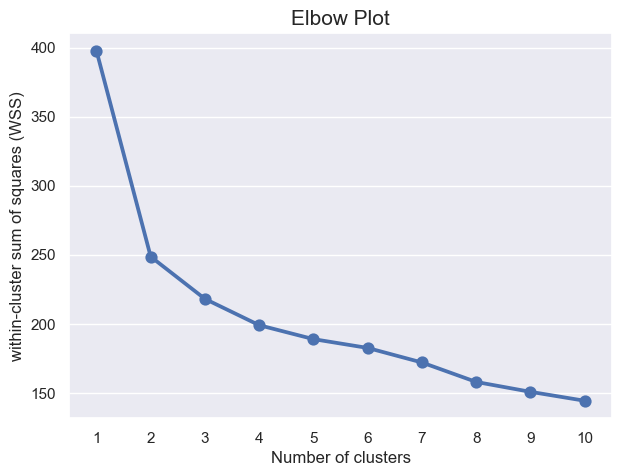

In [492]:
plt.figure(figsize=(7, 5))
sns.pointplot(x=list(range(1, 11)), y=wss)
plt.title("Elbow Plot", size=15)
plt.xlabel("Number of clusters")
plt.ylabel("within-cluster sum of squares (WSS)");

### Silhouette Plot

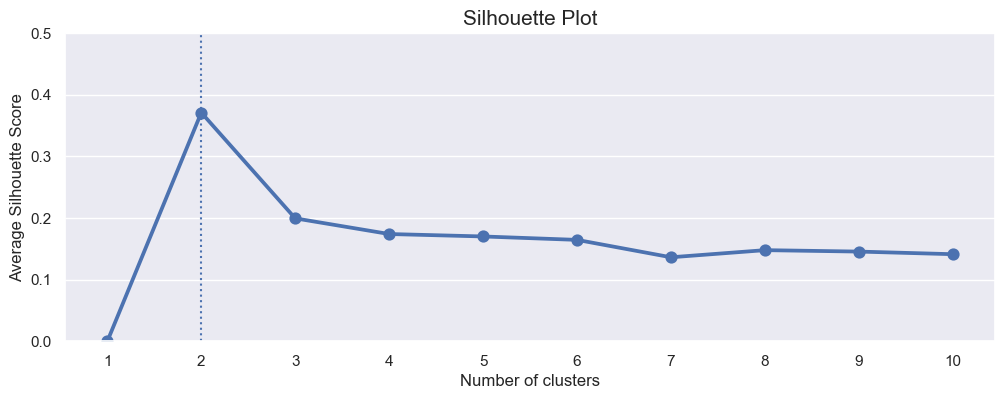

In [442]:
maxkey = [key for key, value in ss.items() if value == max(ss.values())][0]
fig, ax = plt.subplots(figsize=(12, 4))
sns.pointplot(x=list(ss.keys()), y=list(ss.values()))
plt.vlines(x=maxkey - 1, ymax=0, ymin=0.55, linestyles="dotted")
ax.set(ylim=(0, 0.5))
ax.set_title("Silhouette Plot", size=15)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Average Silhouette Score");

From both Elbow and Silhouette plot, the optimum number of clusters suggested by the KMean algorithm is 2.

In [444]:
KM_final = KMeans(n_clusters=2, random_state=0).fit(segmentation_df)
km_cluster_no = KM_final.labels_
behavior_df["KMeans Cluster"] = km_cluster_no

### Visualizing the Clusters using PCA

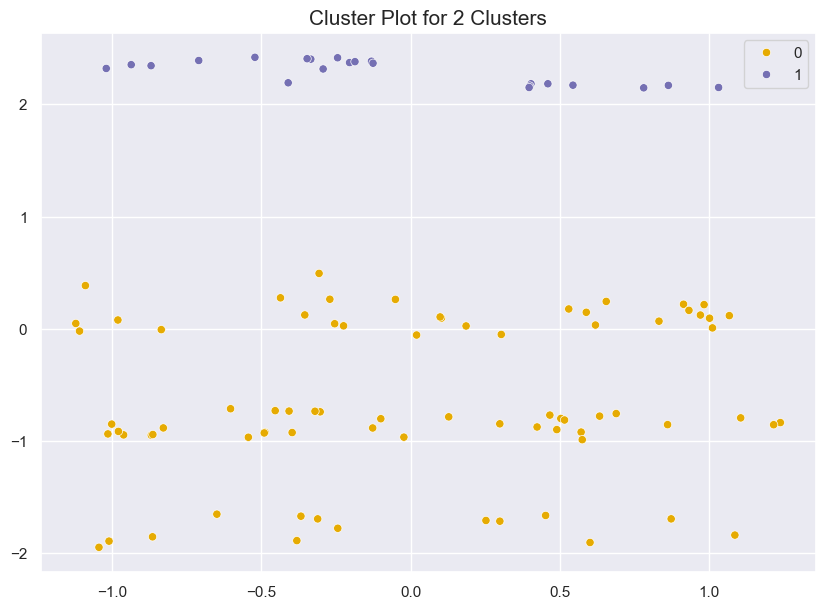

In [447]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(segmentation_df)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=km_cluster_no,
    palette="Dark2_r",
    legend=True,
)
plt.title("Cluster Plot for 2 Clusters", size=15);

The two clusters are clearly separable.

### Profiling the segments

In [452]:
behavior_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price,KMeans Cluster
0,27,Salaried,Single,Post Graduate,0,Yes,No,No,800000,0,800000,i20,800000,1
1,35,Salaried,Married,Post Graduate,2,Yes,Yes,Yes,1400000,600000,2000000,Ciaz,1000000,0
2,45,Business,Married,Graduate,4,Yes,Yes,No,1800000,0,1800000,Duster,1200000,0
3,41,Business,Married,Post Graduate,3,No,No,Yes,1600000,600000,2200000,City,1200000,0
4,31,Salaried,Married,Post Graduate,2,Yes,No,Yes,1800000,800000,2600000,SUV,1600000,0


In [453]:
behavior_df["KMeans Cluster"].value_counts()

KMeans Cluster
0    77
1    22
Name: count, dtype: int64

In [454]:
cluster_0_data = behavior_df[behavior_df["KMeans Cluster"] == 0]
cluster_1_data = behavior_df[behavior_df["KMeans Cluster"] == 1]
cluster_0_data.describe(include="all")

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price,KMeans Cluster
count,77.000000,77,77,77,77.000000,77,77,77,7.700000e+01,7.700000e+01,7.700000e+01,77,7.700000e+01,77.0
unique,NaN,2,2,2,NaN,2,2,2,NaN,NaN,NaN,9,NaN,NaN
top,NaN,Salaried,Married,Post Graduate,NaN,No,No,Yes,NaN,NaN,NaN,SUV,NaN,NaN
freq,NaN,50,75,44,NaN,49,40,44,NaN,NaN,NaN,14,NaN,NaN
mean,38.272727,NaN,NaN,NaN,2.805195,NaN,NaN,NaN,1.877922e+06,6.064935e+05,2.484416e+06,NaN,1.227273e+06,0.0
std,5.557443,NaN,NaN,NaN,0.726183,NaN,NaN,NaN,6.687820e+05,6.372923e+05,1.061908e+06,NaN,4.408832e+05,0.0
min,28.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000e+05,0.000000e+00,2.000000e+05,NaN,7.000000e+05,0.0
25%,35.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,1.400000e+06,0.000000e+00,1.800000e+06,NaN,8.000000e+05,0.0
50%,36.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,1.800000e+06,6.000000e+05,2.200000e+06,NaN,1.200000e+06,0.0
75%,42.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,2.300000e+06,1.100000e+06,3.000000e+06,NaN,1.500000e+06,0.0


For cluster 1:

1. The average age of the buyers in the cluster is 30.
2. The most common profession of the buyers in the cluster is salaried, followed by business.
3. Most of the buyers in the cluster are single.
4. The most common level of education of the buyers in the cluster is Post Graduate, followed by Graduate.
5. The average number of dependents of the buyers in the cluster is 0.
6. The most common loan type of the buyers in the cluster is no loan.
7. The most common wife working status of the buyers in the cluster is no.
8. The average salary of the buyers in the cluster is around 1300000 Indian rupees.
9. The average wife salary of the buyers in the cluster is 300000 Indian rupees.
10. The average total salary of the buyers in the cluster is 1600000 Indian rupees.
11. The most popular make of car purchased by the buyers in the cluster is Baleno, followed by Ciaz and Creata.
12. The average price of the cars purchased by the buyers in the cluster is 1100000 Indian rupees.

These observations indicate that the first cluster comprises young, educated, and well-paid professionals interested in affordable cars. Hatchbacks and sedans, known for their practicality and fuel efficiency, are the most popular choices within this group.

In [456]:
cluster_1_data.describe(include="all")

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,House Loan,Wife Working,Salary,Wife Salary,Total Salary,Make,Price,KMeans Cluster
count,22.000000,22,22,22,22.0,22,22,22,2.200000e+01,2.200000e+01,2.200000e+01,22,2.200000e+01,22.0
unique,NaN,2,2,2,NaN,2,1,2,NaN,NaN,NaN,7,NaN,NaN
top,NaN,Salaried,Single,Post Graduate,NaN,No,No,No,NaN,NaN,NaN,Baleno,NaN,NaN
freq,NaN,14,13,12,NaN,18,22,13,NaN,NaN,NaN,6,NaN,NaN
mean,29.454545,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.240909e+06,2.818182e+05,1.522727e+06,NaN,1.077727e+06,1.0
std,2.631807,NaN,NaN,NaN,0.0,NaN,NaN,NaN,4.101789e+05,3.935629e+05,5.639418e+05,NaN,4.151412e+05,0.0
min,26.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,8.000000e+05,0.000000e+00,8.000000e+05,NaN,1.100000e+05,1.0
25%,27.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,9.000000e+05,0.000000e+00,1.100000e+06,NaN,7.000000e+05,1.0
50%,29.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.250000e+06,0.000000e+00,1.400000e+06,NaN,1.100000e+06,1.0
75%,30.750000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.400000e+06,7.000000e+05,2.000000e+06,NaN,1.500000e+06,1.0


For cluster 2:

1. The average age of the buyers in the cluster is around 40.
2. The most common profession of the buyers in the cluster is salaried, followed by business.
3. Most of the buyers in the cluster are married.
4. The most common level of education of the buyers in the cluster is Post Graduate.
5. The average number of dependents of the buyers in the cluster is 3.
6. The most common loan type of the buyers in the cluster is no loan.
7. The most common wife working status of the buyers in the cluster is yes.
8. The average salary of the buyers in the cluster is 1900000 Indian rupees.
9. The average wife salary of the buyers in the cluster is 600000 Indian rupees.
10. The average total salary of the buyers in the cluster is 2500000 Indian rupees.
11. The most popular make of car purchased by the buyers in the cluster is SUV.
12. The average price of the cars purchased by the buyers in the cluster is 1200000 Indian rupees.

These observations indicate that the second cluster consists of middle-aged, well-educated, and high-income professionals seeking premium vehicles. SUVs, known for their spaciousness and luxury, are the most popular choice within this cluster, especially appealing to families.

## Conclusion

As shown, the two clusters differ significantly in demographics and purchasing behavior. Cluster 1 consists of younger, less affluent professionals seeking affordable cars, while Cluster 2 comprises middle-aged, affluent professionals interested in more expensive vehicles.

Here are some of the key differences between the two clusters:
1. Age: Buyers in Cluster 1 have an average age of 30, while those in Cluster 2 average 40 years old. This indicates that Cluster 1 consists of younger professionals, whereas Cluster 2 includes more experienced professionals.
2. Income: The average total salary of the buyers in Cluster 1 is 1600000, while the average total salary of the buyers in Cluster 2 is 2500000. This suggests that Cluster 1 is made up of less well-off professionals, while Cluster 2 is made up of more well-off professionals.
3. Car preference: The most popular make of car in Cluster 1 is Baleno, Ciaz, and Creata, which are all relatively affordable cars. The most popular make of car in Cluster 2 is SUV, which are typically more expensive cars.

These differences indicate that the two clusters have distinct preferences in cars. Cluster 1 seeks affordable, reliable, and fuel-efficient vehicles, while Cluster 2 favors more luxurious, powerful cars suited to accommodate their families.